In [1]:
# Wetter auf Stundenbasis in Zürich an 3 Orten

# https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte
import pandas as pd

url_cs_2021 = "https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte/download/ugz_ogd_meteo_h1_2021.csv"    
url_cs_2022 = "https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte/download/ugz_ogd_meteo_h1_2022.csv"
url_cs_2023 = "https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte/download/ugz_ogd_meteo_h1_2023.csv"

weather_2021 = pd.read_csv(
    url_cs_2021,
    sep=',',
    encoding='utf-8',
)
weather_2022 = pd.read_csv(
    url_cs_2022,
    sep=',',
    encoding='utf-8',
)
weather_2023 = pd.read_csv(
    url_cs_2023,
    sep=',',
    encoding='utf-8',
)


In [2]:
weather_2021.loc[weather_2021["Standort"] == "Zch_Rosengartenstrasse"]
weather_2021["Datum"] = pd.to_datetime(weather_2021["Datum"], format="%Y-%m-%dT%H:%M+0100")

weather_2022.loc[weather_2022["Standort"] == "Zch_Rosengartenstrasse"]
weather_2022["Datum"] = pd.to_datetime(weather_2022["Datum"], format="%Y-%m-%dT%H:%M+0100")

weather_2023.loc[weather_2023["Standort"] == "Zch_Rosengartenstrasse"]
weather_2023["Datum"] = pd.to_datetime(weather_2023["Datum"], format="%Y-%m-%dT%H:%M+0100")

concatenated_weather = pd.concat([weather_2022, weather_2023, weather_2021], ignore_index=True)
concatenated_weather= concatenated_weather.loc[concatenated_weather["Einheit"] == "W/m2"]
concatenated_weather=concatenated_weather.sort_values(by = "Datum")
concatenated_weather=concatenated_weather.loc[concatenated_weather["Datum"] >= "2021-09-26 00:00:00"]
concatenated_weather=concatenated_weather.loc[concatenated_weather["Datum"] <= "2023-11-09 00:00:00"]

concatenated_weather.to_csv("weather.csv")

In [3]:
sun = concatenated_weather
sun

,Datum,Standort,Parameter,Intervall,Einheit,Wert,Status
505476,2021-09-26 00:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.03,bereinigt
505498,2021-09-26 01:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.03,bereinigt
505520,2021-09-26 02:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.03,bereinigt
505542,2021-09-26 03:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.02,bereinigt
505564,2021-09-26 04:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.03,bereinigt
...,...,...,...,...,...,...,...
357372,2023-11-08 20:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.02,provisorisch
357394,2023-11-08 21:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.03,provisorisch
357416,2023-11-08 22:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.02,provisorisch
357438,2023-11-08 23:00:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.03,provisorisch


In [4]:
# Select relevant columns
sun = sun[["Datum", "Wert"]]

# Change column names
sun.columns = ["Date", "Sunshine"]
sun.set_index("Date", inplace = True)
sun



,Sunshine
Date,
2021-09-26 00:00:00,0.03
2021-09-26 01:00:00,0.03
2021-09-26 02:00:00,0.03
2021-09-26 03:00:00,0.02
2021-09-26 04:00:00,0.03
...,...
2023-11-08 20:00:00,0.02
2023-11-08 21:00:00,0.03
2023-11-08 22:00:00,0.02


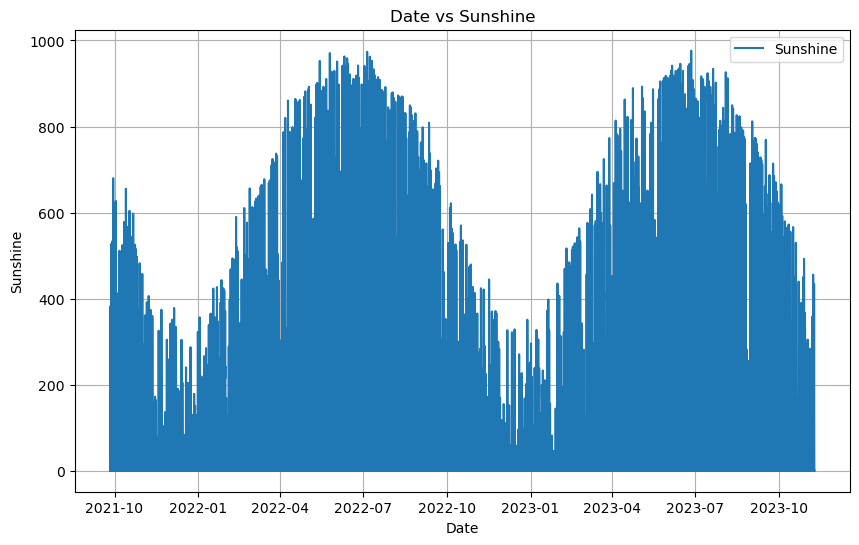

In [5]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sun.index, sun["Sunshine"], label = "Sunshine")

# Formatting
plt.title('Date vs Sunshine')
plt.xlabel('Date')
plt.ylabel('Sunshine')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as st

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.seasonal import seasonal_decompose


plt.style.use("seaborn-v0_8-muted")

In [7]:
# Helpful functions for showing results of analysis

# Show summary statistics for different time frames
def split_series(series):
    X = series.values
    split1, split2 = round(len(X) / 3), round(len(X) / 3)*2
    X1, X2, X3 = X[0:split1], X[split1:split2], X[split2:]
    mean1, mean2, mean3 = X1.mean(), X2.mean(), X3.mean()
    std1, std2, std3 = X1.std(), X2.std(), X3.std()
    print(f"The means are{mean1: 0.2f},{mean2: 0.2f} and{mean3: 0.2f}")
    print(f"The stds are{std1: 0.2f},{std2: 0.2f} and{std3: 0.2f}")

# Run KPSS test (Null hypothesis: x is level or trend stationary)
def kpss_test(series):
    print("Results of KPSS Test:")
    kpsstest = kpss(series, regression="ct", nlags="auto")
    print(f"Test Statistic {kpsstest[0]:0.3f}")
    print(f"p-value: {kpsstest[1]: 0.4f}")
    print(f"Lags used: {kpsstest[2]: 0.0f}")


# Run a Augmented Dickey-Fuller test (Null hypothesis: time series contains a unit root and is non-stationary)
def run_test(series):
    result=adfuller (series, autolag="AIC", regression = "ctt")
    print(f"Results of the AD Fuller test:")
    print(f"Test Statistic: {result[0]: 0.3f}")
    print(f"p-value: {result[1]: 0.4f}")
    
# Plot results
def plot_three(series, title, window_size = 24*7):
    figs = plt.figure(figsize=(10, 6))
    fig, axs = plt.subplots(2,1, figsize=(10,6))
    
    # Set a title
    figs.suptitle(title, fontweight = "bold", fontsize = 16)
    
    gs = figs.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    
    # Create the Axes for subplots.
    ax = figs.add_subplot(gs[1, 0])
    ax.tick_params(axis='x', which='major')
    ax_histx = figs.add_subplot(gs[0, 0], )
    ax_histy = figs.add_subplot(gs[1, 1])

    
    # Format x axis
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    
    # Populate the Axes.
    ax.plot(series, alpha = 0.8)
    ax.set_xlabel("Passengers")
    ax_histx.hist(series, alpha=0.5, edgecolor = "black", color = "pink")
    # Add moving average 
    rolling = series.rolling(window=window_size).mean()
    ax_histy.hist(rolling, alpha=0.5, orientation="horizontal", edgecolor = "black", color = "pink")
    ax_histy.set_yticklabels([])
    ax_histx.set_xticklabels([])
    ax_histx.set_title("Distribution of Sunshine")
    ax_histy.set_title(f'Rolling means', rotation=0)
    
    # Plot series and Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    st.graphics.tsa.plot_pacf(series, ax = axs[0], lags = 24)
    st.graphics.tsa.plot_acf(series, axs[1], lags = 24)
    plt.tight_layout()
    # Run the tests
    run_test(series)
    print("----------------")
    kpss_test(series)
    print("----------------")
    split_series(series)

In [8]:
#transform = np.log(sun)
transform = sun
transform

,Sunshine
Date,
2021-09-26 00:00:00,0.03
2021-09-26 01:00:00,0.03
2021-09-26 02:00:00,0.03
2021-09-26 03:00:00,0.02
2021-09-26 04:00:00,0.03
...,...
2023-11-08 20:00:00,0.02
2023-11-08 21:00:00,0.03
2023-11-08 22:00:00,0.02


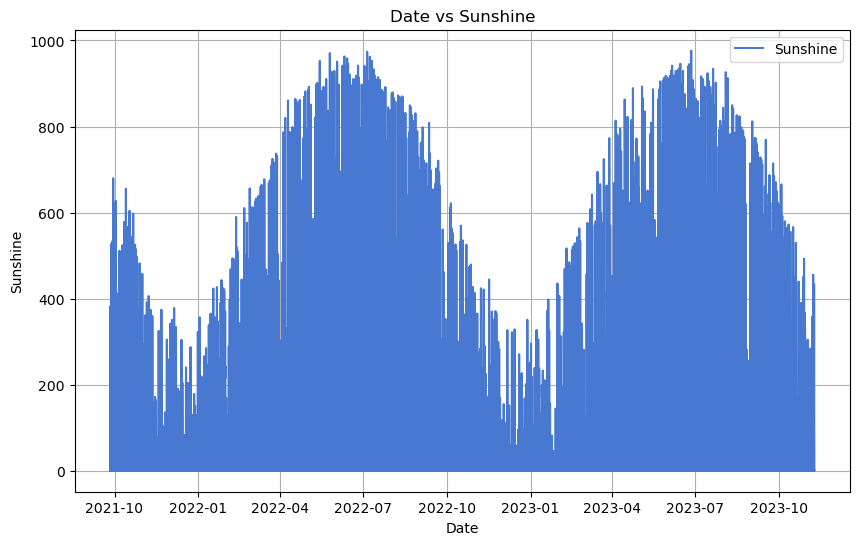

In [9]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(transform.index, transform["Sunshine"], label = "Sunshine")

# Formatting
plt.title('Date vs Sunshine')
plt.xlabel('Date')
plt.ylabel('Sunshine')
plt.legend()
plt.grid(True)
plt.show()


Results of the AD Fuller test:
Test Statistic: -28.901
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.002
p-value:  0.1000
Lags used:  54
----------------
The means are 0.38,-0.17 and 0.02
The stds are 154.06, 165.59 and 212.16


/var/folders/bp/ly_w1kqj7gs4yy61jdj69bqr0000gn/T/ipykernel_35075/2081436272.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


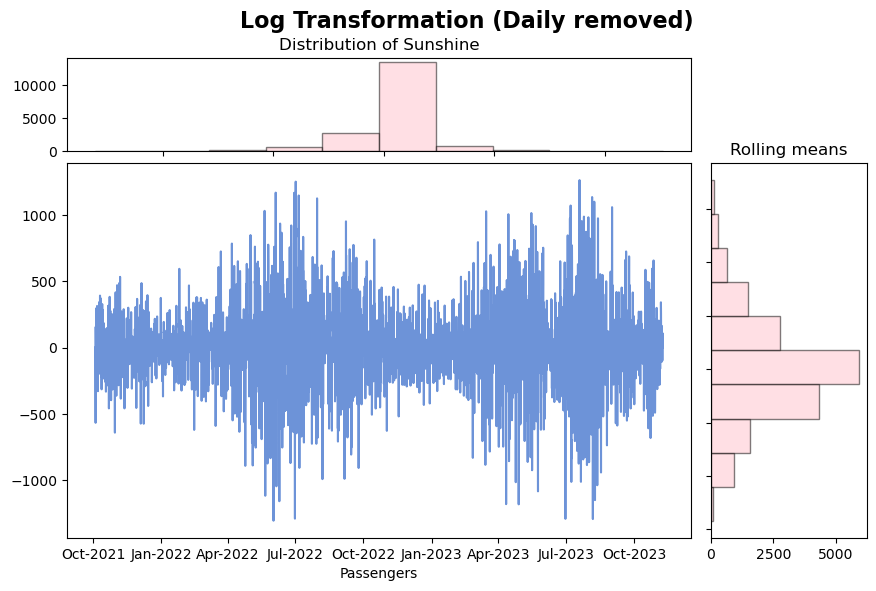

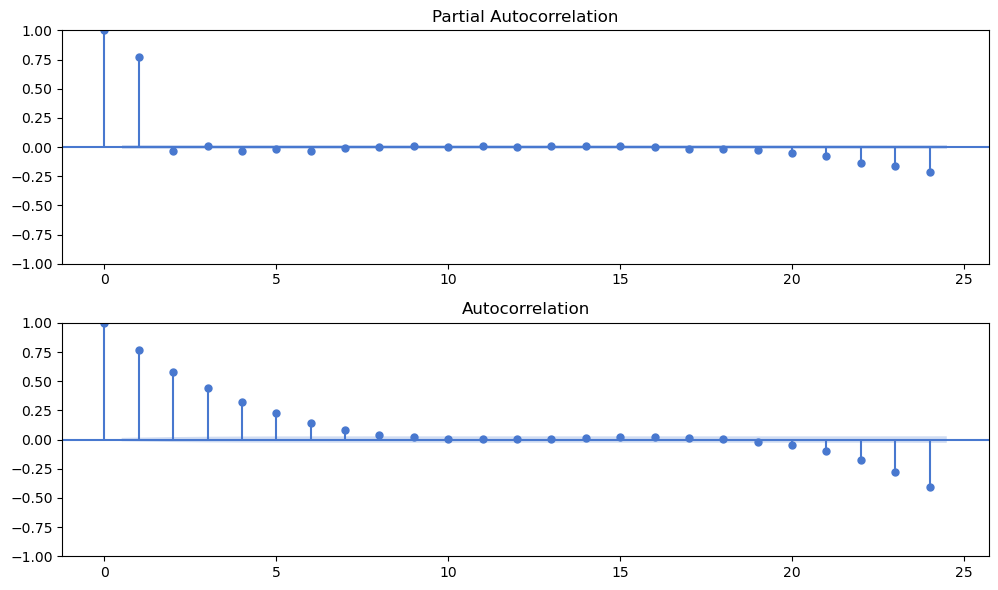

In [11]:
# Eliminate daily seasonality
daily_24 = transform.diff(24).diff(24*7).dropna()
plot_three(daily_24.Sunshine, "Log Transformation (Daily removed)")

,Sunshine
Date,
2021-10-04 00:00:00,0.508125
2021-10-04 01:00:00,0.508125
2021-10-04 02:00:00,0.508121
2021-10-04 03:00:00,0.508125
2021-10-04 04:00:00,0.508125


Results of the AD Fuller test:
Test Statistic: -28.901
p-value:  0.0000
----------------
Results of KPSS Test:
Test Statistic 0.002
p-value:  0.1000
Lags used:  54
----------------
The means are 0.51, 0.51 and 0.51
The stds are 0.06, 0.06 and 0.08


/var/folders/bp/ly_w1kqj7gs4yy61jdj69bqr0000gn/T/ipykernel_35075/2081436272.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(series, regression="ct", nlags="auto")


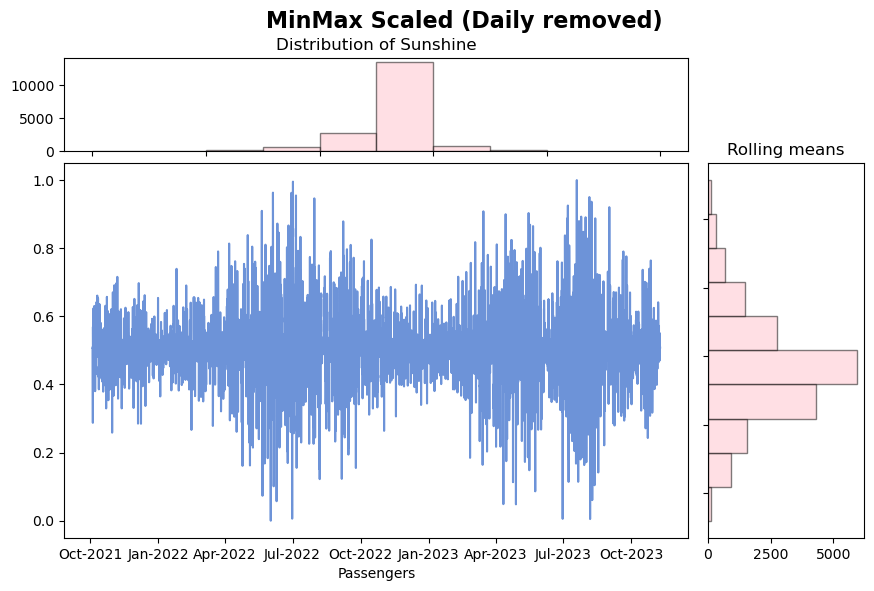

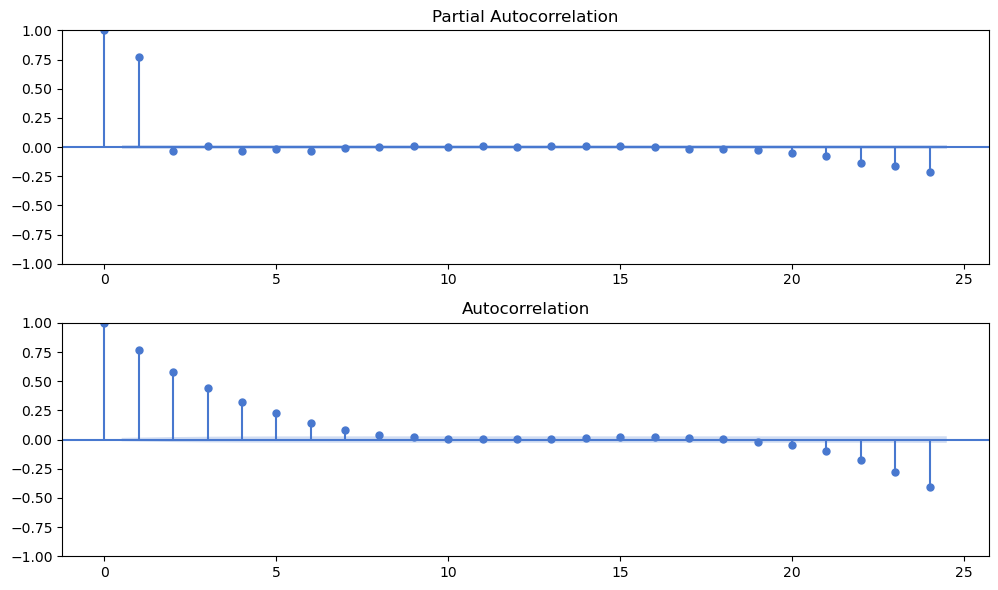

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
daily_24["Sunshine"] = scaler.fit_transform(daily_24["Sunshine"].values.reshape(-1, 1))
display(daily_24.head())
plot_three(daily_24.Sunshine, "MinMax Scaled (Daily removed)")

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
daily_24["Sunshine"] = scaler.fit_transform(daily_24["Sunshine"].values.reshape(-1, 1))
display(daily_24.head())

,Sunshine
Date,
2021-10-04 00:00:00,0.508125
2021-10-04 01:00:00,0.508125
2021-10-04 02:00:00,0.508121
2021-10-04 03:00:00,0.508125
2021-10-04 04:00:00,0.508125


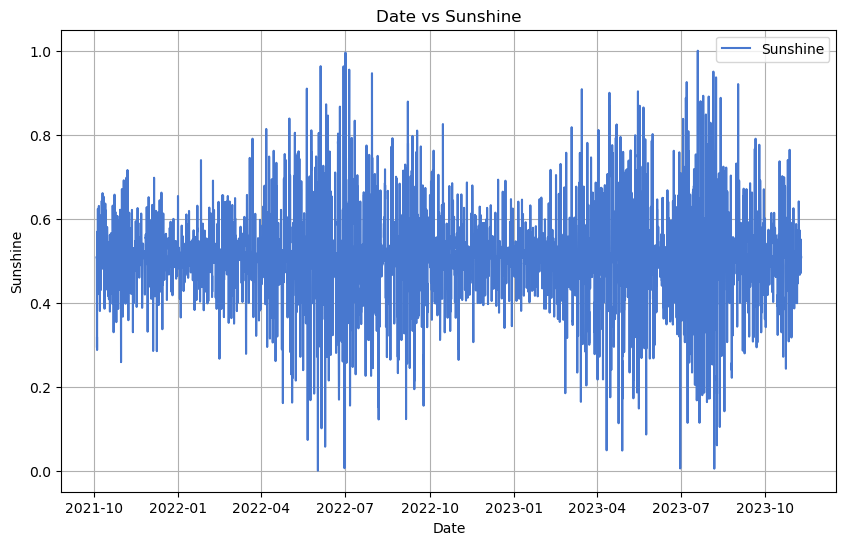

In [14]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_24.index, daily_24["Sunshine"], label = "Sunshine")

# Formatting
plt.title('Date vs Sunshine')
plt.xlabel('Date')
plt.ylabel('Sunshine')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
daily_24.to_csv("sunshine_scaled.csv")